In [1]:
#@title Mount google drive

from google.colab import drive
drive.mount('/content/drive')

%cd './drive/MyDrive/hMeNets'

# %cd '../'
# !git clone https://github.com/Selbias/hMeNets.git
# #cd './hMeNets'

Mounted at /content/drive
/content/drive/MyDrive/hMeNets


In [2]:
import os
import time
import copy
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm.auto import tqdm
from sklearn.linear_model import LinearRegression

%cd './PyTorch'
from likelihood_hetero import multivariate_nll_hetero_i, multivariate_njll_hetero_i, multivariate_nhll_hetero_i
from h_likelihood_arbitrary import nhll_hetero_arbitrary, Sigma_module_rev
from util import make_reproducibility, TensorDataset, convert_to_spherical, convert_to_xyz, mae, make_arbitrary_masking, k_fold_index
from model import *
from hglm_hetero_arbitrary import hetero_arbitrary_without_val
%cd '../'

/content/drive/MyDrive/hMeNets/PyTorch
/content/drive/MyDrive/hMeNets


# Data Load

In [3]:
#@title Load preprocessed data

# images, head_poses and gazes are already flipped

id_vector = np.load('./data/MPIIGaze_ids.npy')
is_right = np.load('./data/MPIIGaze_is_right.npy')
images = np.load('./data/MPIIGaze_images.npy')
head_poses = np.load('./data/MPIIGaze_head_poses.npy')
gazes = np.load('./data/MPIIGaze_gazes.npy')

In [4]:
#@title data balancing

indice_list = []

np.random.seed(42)
for i in tqdm(range(15)) :
    if i < 10 :
        left_indice = np.random.choice(np.where((id_vector == f"p0{i}") & np.invert(is_right))[0], size=1500, replace=False)
        right_indice = np.random.choice(np.where((id_vector == f"p0{i}") & is_right)[0], size=1500, replace=False)
        total_indice = np.concatenate([left_indice, right_indice])
    elif i != 13 :
        left_indice = np.random.choice(np.where((id_vector == f"p{i}") & np.invert(is_right))[0], size=1500, replace=False)
        right_indice = np.random.choice(np.where((id_vector == f"p{i}") & is_right)[0], size=1500, replace=False)
        total_indice = np.concatenate([left_indice, right_indice])
    else :
        left_indice = np.random.choice(np.where((id_vector == f"p{i}") & np.invert(is_right))[0], size=1500, replace=True)
        right_indice = np.random.choice(np.where((id_vector == f"p{i}") & is_right)[0], size=1500, replace=True)
        total_indice = np.concatenate([left_indice, right_indice])
    indice_list.append(total_indice)

selected_ids = [id_vector[indice] for indice in indice_list]
selected_images = [torch.as_tensor(images[indice]).float() for indice in indice_list]
selected_head_poses = [torch.as_tensor(head_poses[indice]).float() for indice in indice_list]
selected_gazes = [torch.as_tensor(gazes[indice]).float() for indice in indice_list]

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
# #@title test
# total_ids = np.concatenate(selected_ids)
# total_images = torch.cat(selected_images)
# total_hps = torch.cat(selected_head_poses)
# total_gazes = torch.cat(selected_gazes)

# total_N = len(total_ids)
# num_fold=10
# cv_seed = 100
# cv_indice_list = [k_fold_index(N=3000, k=num_fold, randomize=True, SEED=cv_seed + i) for i in range(15)]
# total_ids_unique = np.unique(total_ids)

# %cd './PyTorch'
# from likelihood_hetero import multivariate_nll_hetero_i, multivariate_njll_hetero_i, multivariate_nhll_hetero_i
# from h_likelihood_arbitrary import nhll_hetero_arbitrary, Sigma_module_rev
# from hglm_hetero_arbitrary import hetero_arbitrary_without_val
# %cd '../'

# for fold in [0] :
#     train_indice = np.concatenate([np.where(total_ids == total_ids_unique[i])[0][cv_indice_list[i][fold][0]] for i in range(15)])
#     test_indice = np.concatenate([np.where(total_ids == total_ids_unique[i])[0][cv_indice_list[i][fold][1]] for i in range(15)])
#     print(test_indice[:5])

#     train_ids = total_ids[train_indice]
#     train_images = total_images[train_indice].float()
#     train_hps = total_hps[train_indice].float()
#     train_gazes = total_gazes[train_indice].float()

#     test_ids = total_ids[test_indice]
#     test_images = total_images[test_indice].float()
#     test_hps = total_hps[test_indice].float()
#     test_gazes = total_gazes[test_indice].float()

#     hetero_arbitrary_without_val(
#         train_ids, train_images, train_hps, train_gazes,
#         test_ids, test_images, test_hps, test_gazes,
#         ResNet_batchnorm.ResNet_batchnorm, hidden_features=500, K=2,
#         mean_lr=5e-3, variance_lr=1e-3, weight_decay=0, batch_size=1000,
#         pretrain_iter=1, m_pretrain_epoch=50, v_pretrain_epoch=1, max_iter=1, mean_epoch=1, v_step_iter=1, patience=10,
#         device=torch.device('cuda:0'), experiment_name='test', SEED=10,
#         normalize=True, deg=True, test_unseen=False, weighted=True, variance_check=True, verbose=False, bins=50, reset_opt=False)




In [7]:
device = torch.device('cuda:0')
seed = 10

experiment_name = '0.2.0_loocv_reset'
batch_size = 1000
pretrain_iter = 1
m_pretrain_epoch = 50
v_pretrain_epoch = 20
max_iter = 150
mean_epoch = 10
v_step_iter = 100
patience = 10
mean_lr = 5e-3
variance_lr = 1e-3
weight_decay = 0
hidden_features = 500
test_unseen = True
reset_opt=True

In [8]:
res_list = []

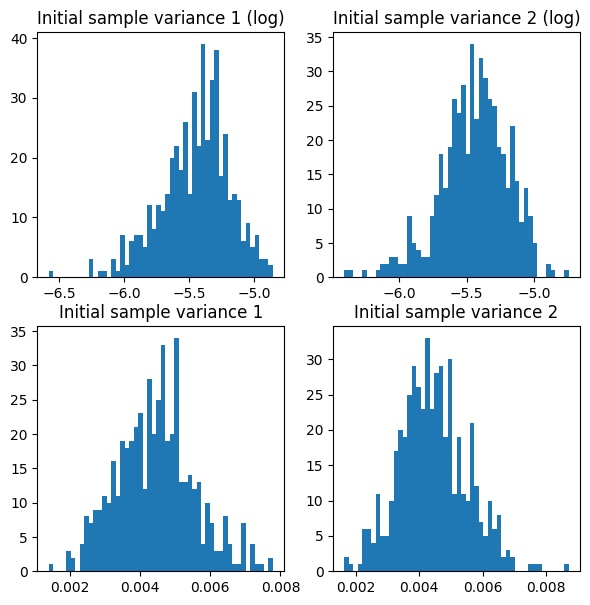

Mean Pretrain starts


  0%|          | 0/1 [00:00<?, ?it/s]

0-th epoch last batch Pretrain h-lik loss (m-step) : 35.07863998413086
1-th epoch last batch Pretrain h-lik loss (m-step) : 23.734344482421875
2-th epoch last batch Pretrain h-lik loss (m-step) : 21.098834991455078
3-th epoch last batch Pretrain h-lik loss (m-step) : 18.146669387817383
4-th epoch last batch Pretrain h-lik loss (m-step) : 17.387544631958008
5-th epoch last batch Pretrain h-lik loss (m-step) : 14.42881965637207
6-th epoch last batch Pretrain h-lik loss (m-step) : 12.592565536499023
7-th epoch last batch Pretrain h-lik loss (m-step) : 11.016952514648438
8-th epoch last batch Pretrain h-lik loss (m-step) : 9.160503387451172
9-th epoch last batch Pretrain h-lik loss (m-step) : 8.744765281677246
10-th epoch last batch Pretrain h-lik loss (m-step) : 8.58186149597168
11-th epoch last batch Pretrain h-lik loss (m-step) : 7.616227149963379
12-th epoch last batch Pretrain h-lik loss (m-step) : 6.164884567260742
13-th epoch last batch Pretrain h-lik loss (m-step) : 6.2123947143554

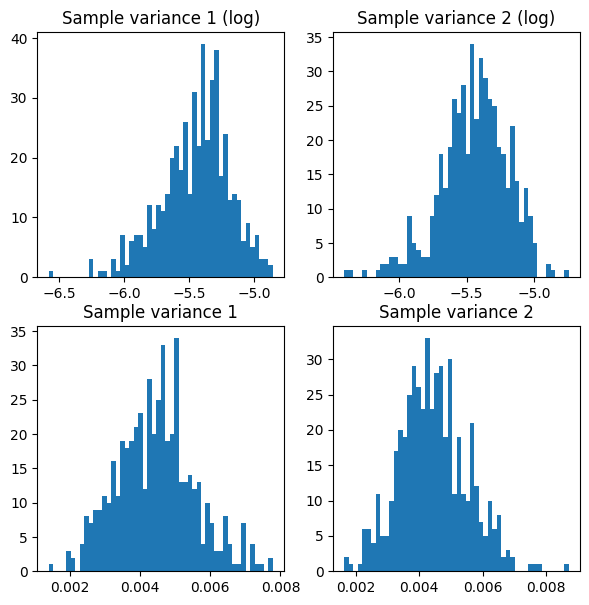

Mean Pretrain spends 253.1858 sec
Variance Pretrain starts


  0%|          | 0/20 [00:00<?, ?it/s]

0-th epoch last batch Pretrain h-lik loss (v-step) : 4.959836006164551
1-th epoch last batch Pretrain h-lik loss (v-step) : 4.322262287139893
2-th epoch last batch Pretrain h-lik loss (v-step) : 4.423554420471191
3-th epoch last batch Pretrain h-lik loss (v-step) : 4.322017192840576
4-th epoch last batch Pretrain h-lik loss (v-step) : 4.397091865539551
5-th epoch last batch Pretrain h-lik loss (v-step) : 4.2389326095581055
6-th epoch last batch Pretrain h-lik loss (v-step) : 4.252067565917969
7-th epoch last batch Pretrain h-lik loss (v-step) : 4.406862258911133
8-th epoch last batch Pretrain h-lik loss (v-step) : 4.61141300201416
9-th epoch last batch Pretrain h-lik loss (v-step) : 4.455599308013916
10-th epoch last batch Pretrain h-lik loss (v-step) : 4.252551078796387
11-th epoch last batch Pretrain h-lik loss (v-step) : 4.074483394622803
12-th epoch last batch Pretrain h-lik loss (v-step) : 4.2350993156433105
13-th epoch last batch Pretrain h-lik loss (v-step) : 4.459165096282959
1

  0%|          | 0/150 [00:00<?, ?it/s]

0-th epoch full h-lik loss (M-step) : 52.0807991027832
1-th epoch full h-lik loss (M-step) : 23.12523651123047
2-th epoch full h-lik loss (M-step) : 19.160558700561523
3-th epoch full h-lik loss (M-step) : 15.861084938049316
4-th epoch full h-lik loss (M-step) : 17.379859924316406
5-th epoch full h-lik loss (M-step) : 20.88006591796875
6-th epoch full h-lik loss (M-step) : 14.064010620117188
7-th epoch full h-lik loss (M-step) : 14.443282127380371
8-th epoch full h-lik loss (M-step) : 12.088464736938477
9-th epoch full h-lik loss (M-step) : 12.584178924560547
9-th V-step train loss : 7.990585803985596
19-th V-step train loss : 7.239339828491211
29-th V-step train loss : 7.187253952026367
39-th V-step train loss : 7.167024612426758
49-th V-step train loss : 7.135687351226807
59-th V-step train loss : 7.103811740875244
69-th V-step train loss : 7.081377983093262
79-th V-step train loss : 7.0664262771606445
89-th V-step train loss : 7.052799224853516
99-th V-step train loss : 7.0398426055

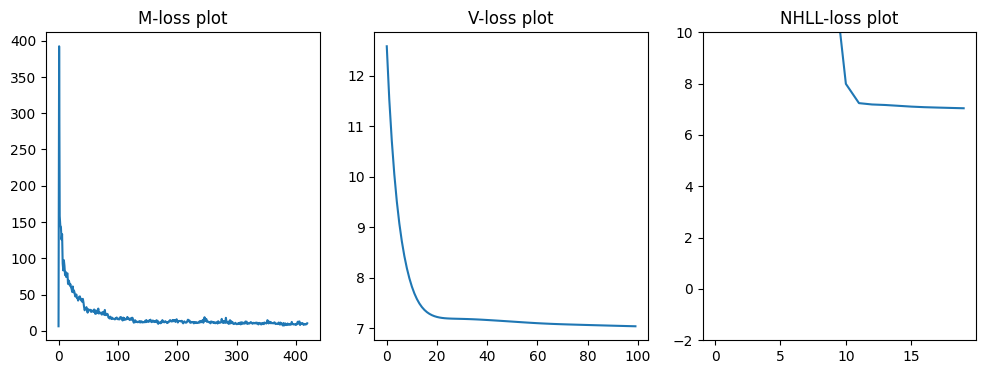

Train loss item : 7.039106369018555
0-th main train train MAE, MSE, NLL, NJLL, NHLL : 1.2312 deg, 1.0448, 5.3537, 6.1874,  7.0386
0-th main train test MAE, MSE, NLL : 5.4149 deg, 18.2229, 9.3425
0-th main train test MAE, MSE, NLL (adjusted y_hat) : 4.0516 deg, 11.5479, 9.4742


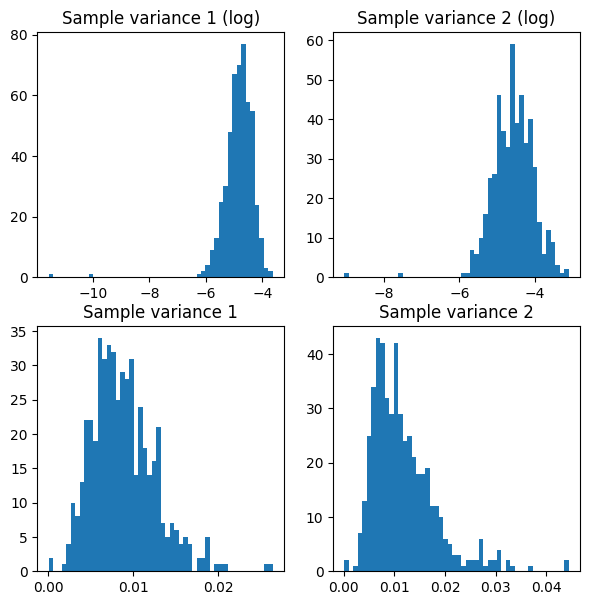

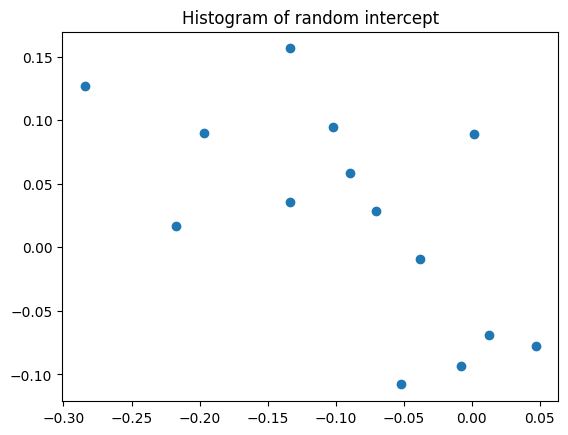

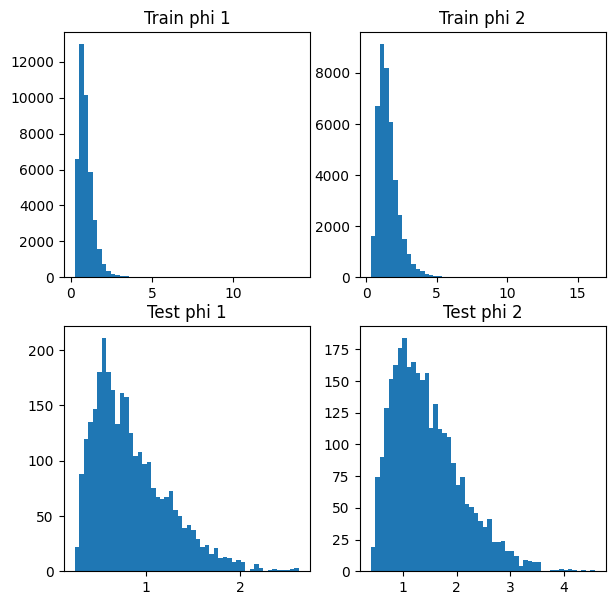

0-th epoch full h-lik loss (M-step) : 9.304298400878906
1-th epoch full h-lik loss (M-step) : 7.33358907699585
2-th epoch full h-lik loss (M-step) : 7.312167167663574
3-th epoch full h-lik loss (M-step) : 7.205618858337402
4-th epoch full h-lik loss (M-step) : 8.197458267211914
5-th epoch full h-lik loss (M-step) : 6.934259414672852
6-th epoch full h-lik loss (M-step) : 7.974173545837402
7-th epoch full h-lik loss (M-step) : 6.754504203796387
8-th epoch full h-lik loss (M-step) : 7.083761215209961
9-th epoch full h-lik loss (M-step) : 6.513216018676758
9-th V-step train loss : 6.408635139465332
19-th V-step train loss : 6.364559650421143
29-th V-step train loss : 6.338696479797363
39-th V-step train loss : 6.320232391357422
49-th V-step train loss : 6.305906295776367
59-th V-step train loss : 6.293609619140625
69-th V-step train loss : 6.282601356506348
79-th V-step train loss : 6.272528171539307
89-th V-step train loss : 6.263125419616699
99-th V-step train loss : 6.254246711730957


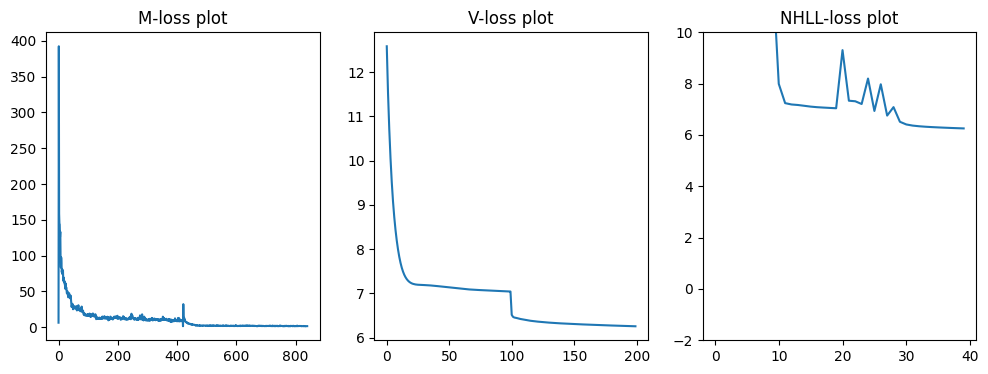

Train loss item : 6.253740310668945
1-th main train train MAE, MSE, NLL, NJLL, NHLL : 1.0345 deg, 0.7258, 4.7082, 5.3340,  6.2534
1-th main train test MAE, MSE, NLL : 5.2413 deg, 17.1961, 10.3282
1-th main train test MAE, MSE, NLL (adjusted y_hat) : 3.9827 deg, 11.2412, 10.5734


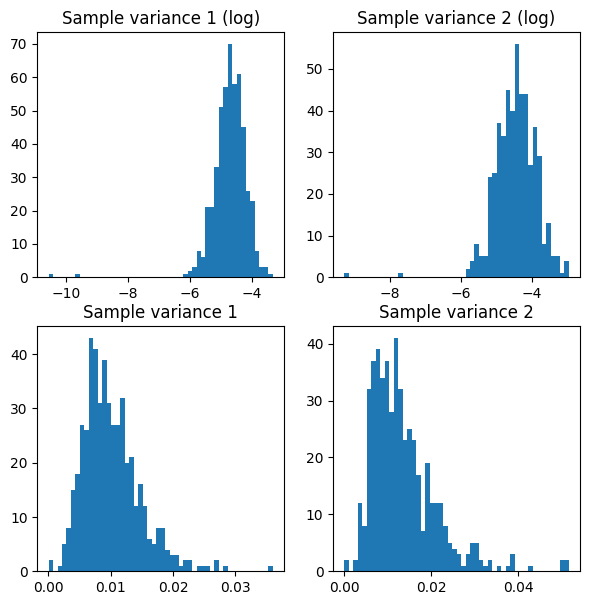

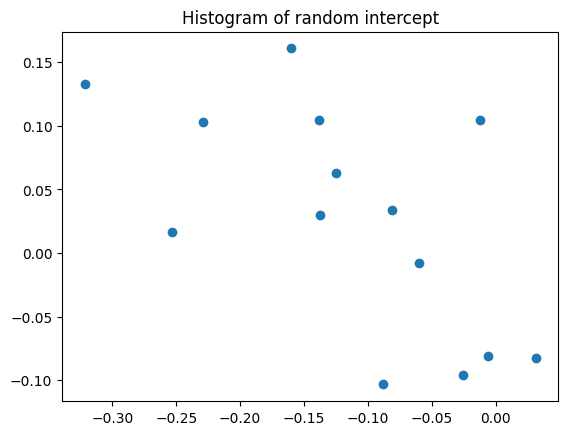

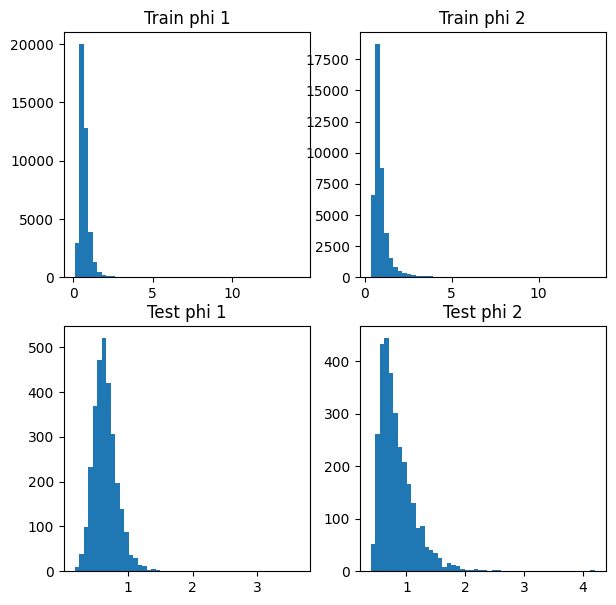

0-th epoch full h-lik loss (M-step) : 8.507584571838379
1-th epoch full h-lik loss (M-step) : 6.342672824859619
2-th epoch full h-lik loss (M-step) : 6.026819705963135
3-th epoch full h-lik loss (M-step) : 7.162825107574463
4-th epoch full h-lik loss (M-step) : 6.500225067138672
5-th epoch full h-lik loss (M-step) : 6.979070663452148
6-th epoch full h-lik loss (M-step) : 6.394775390625
7-th epoch full h-lik loss (M-step) : 6.053084373474121
8-th epoch full h-lik loss (M-step) : 7.0486040115356445
9-th epoch full h-lik loss (M-step) : 7.114953994750977
9-th V-step train loss : 6.768984317779541
19-th V-step train loss : 6.709168434143066
29-th V-step train loss : 6.682232856750488
39-th V-step train loss : 6.662045478820801
49-th V-step train loss : 6.646445274353027
59-th V-step train loss : 6.633932113647461
69-th V-step train loss : 6.622797966003418
79-th V-step train loss : 6.612555503845215
89-th V-step train loss : 6.603059768676758
99-th V-step train loss : 6.594161033630371


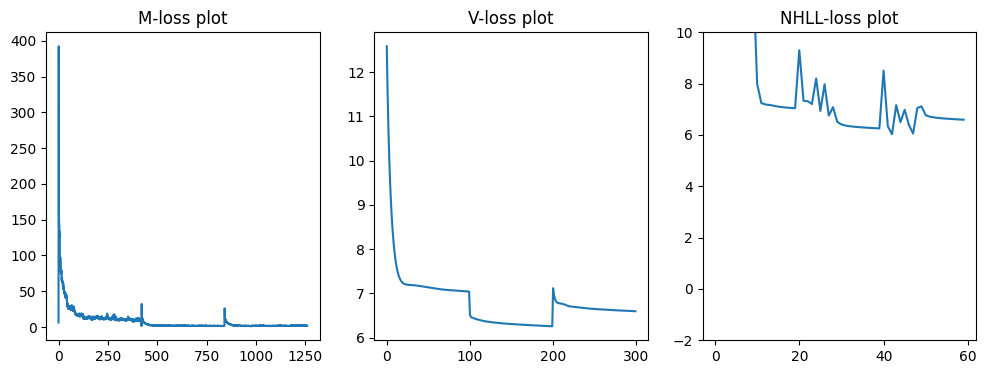

Train loss item : 6.593703269958496
2-th main train train MAE, MSE, NLL, NJLL, NHLL : 1.1960 deg, 0.9602, 4.8755, 5.7398,  6.5933
2-th main train test MAE, MSE, NLL : 5.1949 deg, 16.9471, 9.6745
2-th main train test MAE, MSE, NLL (adjusted y_hat) : 3.8935 deg, 10.6893, 9.8894


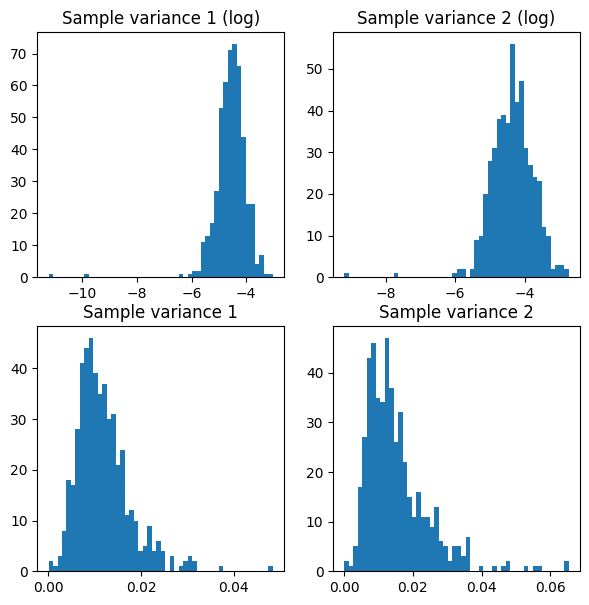

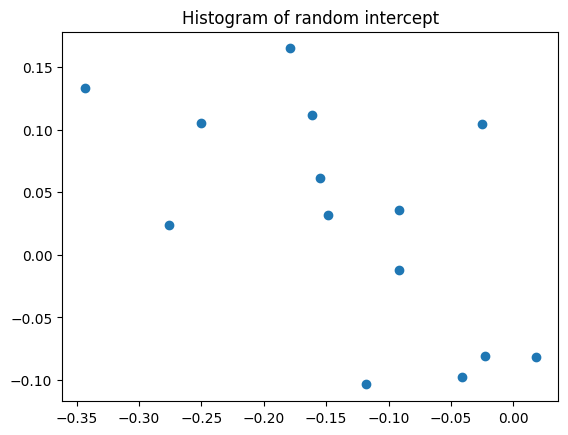

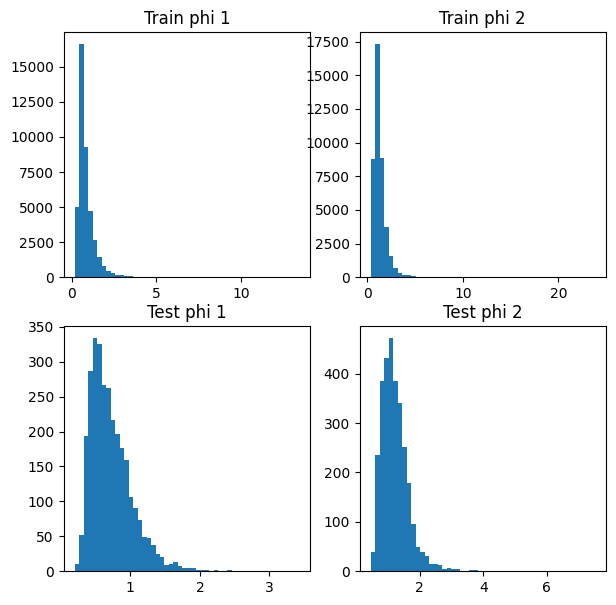

0-th epoch full h-lik loss (M-step) : 7.117760181427002
1-th epoch full h-lik loss (M-step) : 6.357295513153076
2-th epoch full h-lik loss (M-step) : 6.3886003494262695
3-th epoch full h-lik loss (M-step) : 6.736557483673096
4-th epoch full h-lik loss (M-step) : 6.04681921005249
5-th epoch full h-lik loss (M-step) : 6.16813850402832
6-th epoch full h-lik loss (M-step) : 7.59943962097168
7-th epoch full h-lik loss (M-step) : 7.0059051513671875
8-th epoch full h-lik loss (M-step) : 6.517394065856934
9-th epoch full h-lik loss (M-step) : 6.494558334350586
9-th V-step train loss : 6.170372009277344
19-th V-step train loss : 6.113256454467773
29-th V-step train loss : 6.077329635620117
39-th V-step train loss : 6.054638862609863
49-th V-step train loss : 6.040257930755615
59-th V-step train loss : 6.028473854064941
69-th V-step train loss : 6.018108367919922
79-th V-step train loss : 6.008728981018066
89-th V-step train loss : 6.000026226043701
99-th V-step train loss : 5.991793155670166


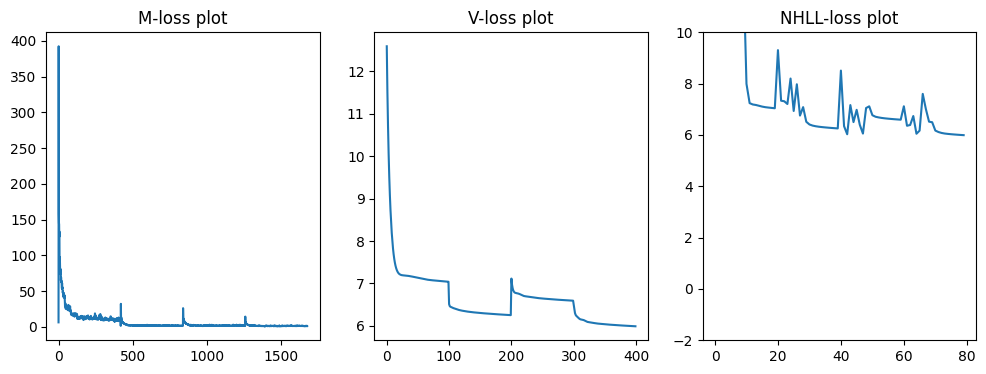

Train loss item : 5.991390228271484
3-th main train train MAE, MSE, NLL, NJLL, NHLL : 1.0218 deg, 0.7142, 4.3222, 5.0546,  5.9910
3-th main train test MAE, MSE, NLL : 5.0079 deg, 15.9866, 11.1238
3-th main train test MAE, MSE, NLL (adjusted y_hat) : 4.0883 deg, 11.6818, 11.4781


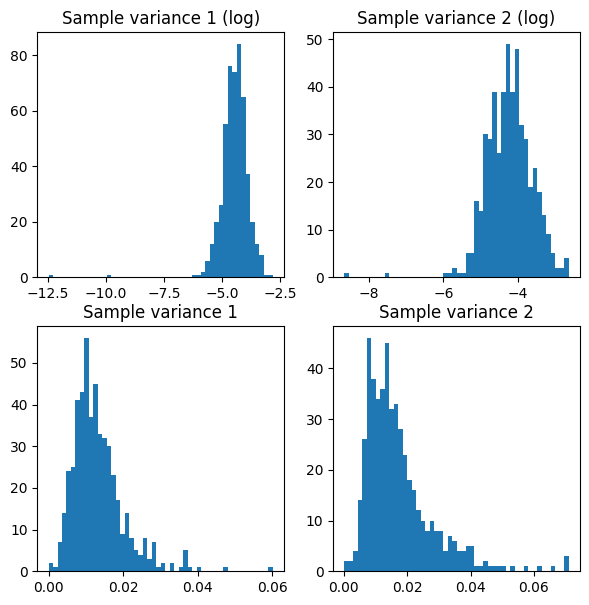

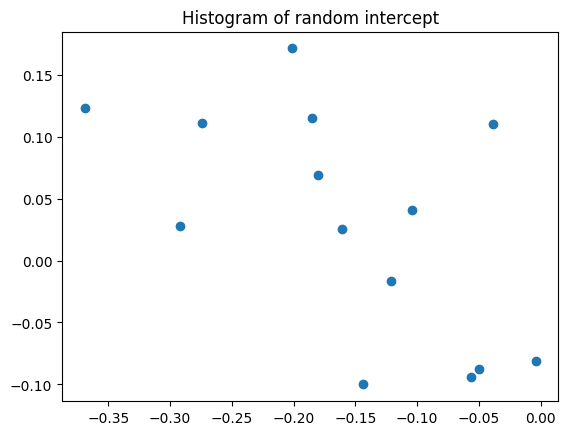

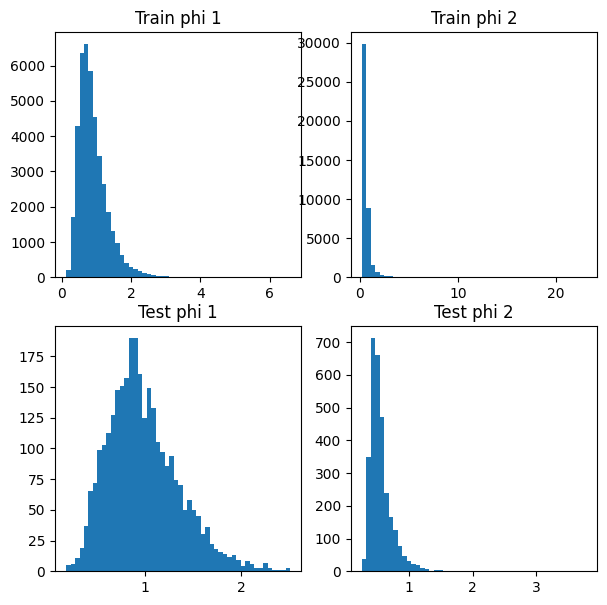

0-th epoch full h-lik loss (M-step) : 6.32221794128418
1-th epoch full h-lik loss (M-step) : 6.05987548828125
2-th epoch full h-lik loss (M-step) : 6.616677284240723
3-th epoch full h-lik loss (M-step) : 7.428013801574707
4-th epoch full h-lik loss (M-step) : 6.248476505279541
5-th epoch full h-lik loss (M-step) : 6.530274391174316
6-th epoch full h-lik loss (M-step) : 5.956748008728027
7-th epoch full h-lik loss (M-step) : 5.590207099914551
8-th epoch full h-lik loss (M-step) : 5.455038070678711
9-th epoch full h-lik loss (M-step) : 5.935222625732422
9-th V-step train loss : 5.5825910568237305
19-th V-step train loss : 5.518805980682373
29-th V-step train loss : 5.475205421447754
39-th V-step train loss : 5.451456069946289
49-th V-step train loss : 5.434344291687012
59-th V-step train loss : 5.420767784118652
69-th V-step train loss : 5.40894889831543
79-th V-step train loss : 5.3983473777771
89-th V-step train loss : 5.388584136962891
99-th V-step train loss : 5.37944221496582


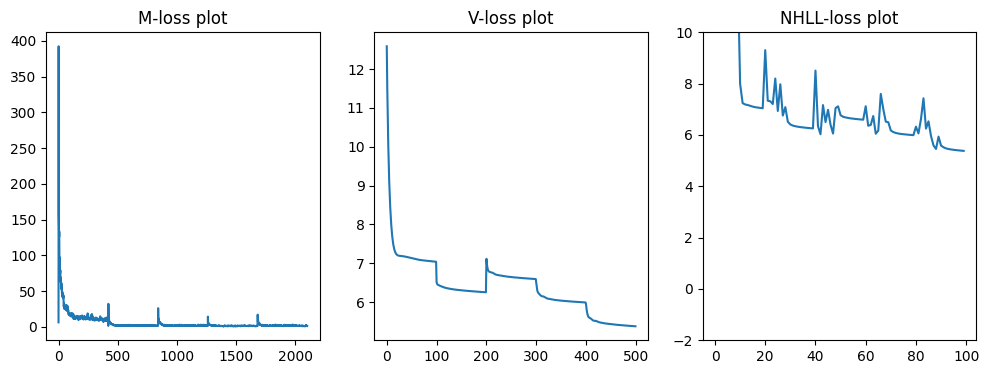

Train loss item : 5.379082679748535
4-th main train train MAE, MSE, NLL, NJLL, NHLL : 0.8950 deg, 0.5520, 3.7174, 4.3900,  5.3786
4-th main train test MAE, MSE, NLL : 5.0180 deg, 15.9943, 13.7126
4-th main train test MAE, MSE, NLL (adjusted y_hat) : 4.0049 deg, 11.1601, 14.2379


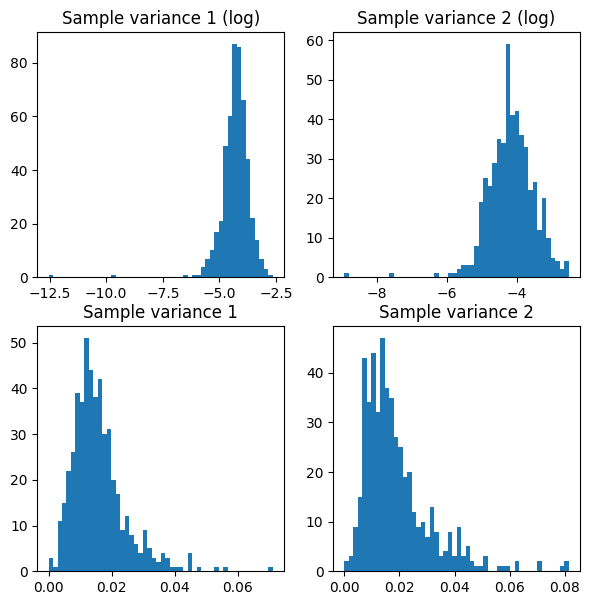

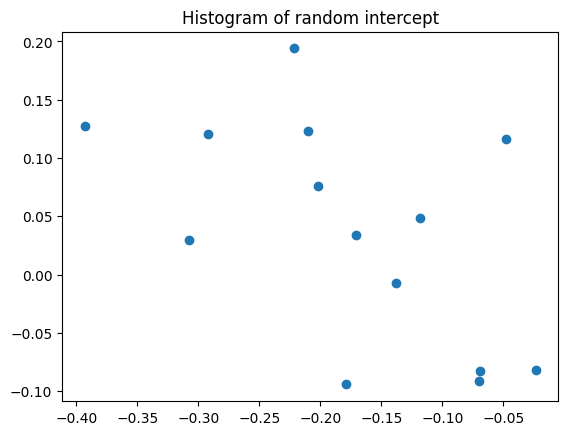

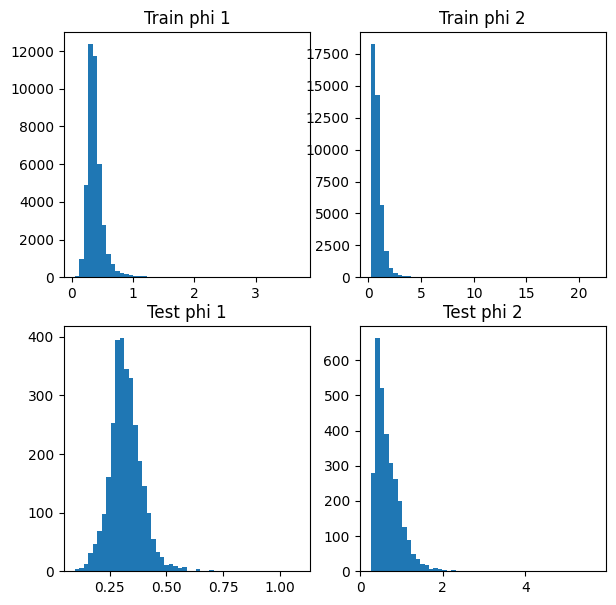

0-th epoch full h-lik loss (M-step) : 6.449483871459961
1-th epoch full h-lik loss (M-step) : 6.047842025756836
2-th epoch full h-lik loss (M-step) : 5.969292640686035
3-th epoch full h-lik loss (M-step) : 5.693716049194336
4-th epoch full h-lik loss (M-step) : 6.322983741760254
5-th epoch full h-lik loss (M-step) : 6.546401023864746
6-th epoch full h-lik loss (M-step) : 6.290329933166504
7-th epoch full h-lik loss (M-step) : 6.767433166503906
8-th epoch full h-lik loss (M-step) : 6.831423759460449
9-th epoch full h-lik loss (M-step) : 5.8792524337768555
9-th V-step train loss : 5.653928756713867
19-th V-step train loss : 5.629060745239258
29-th V-step train loss : 5.601499557495117
39-th V-step train loss : 5.584226608276367
49-th V-step train loss : 5.570934772491455
59-th V-step train loss : 5.559834957122803
69-th V-step train loss : 5.550107002258301
79-th V-step train loss : 5.541416168212891
89-th V-step train loss : 5.533349990844727
99-th V-step train loss : 5.525777339935303


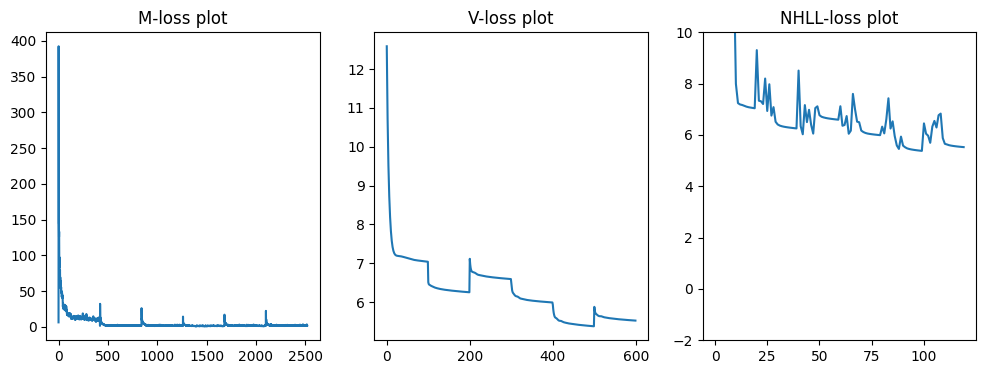

Train loss item : 5.5254411697387695
5-th main train train MAE, MSE, NLL, NJLL, NHLL : 0.9046 deg, 0.5485, 3.8677, 4.5733,  5.5250
5-th main train test MAE, MSE, NLL : 5.2183 deg, 17.2429, 12.9999
5-th main train test MAE, MSE, NLL (adjusted y_hat) : 4.1793 deg, 11.9413, 13.5174


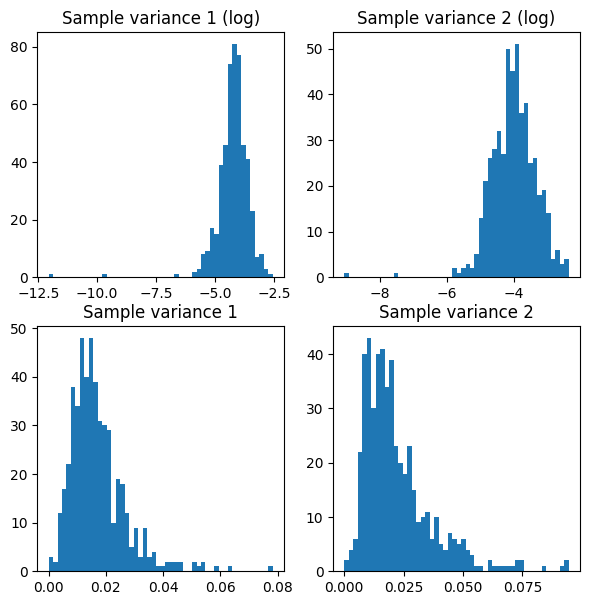

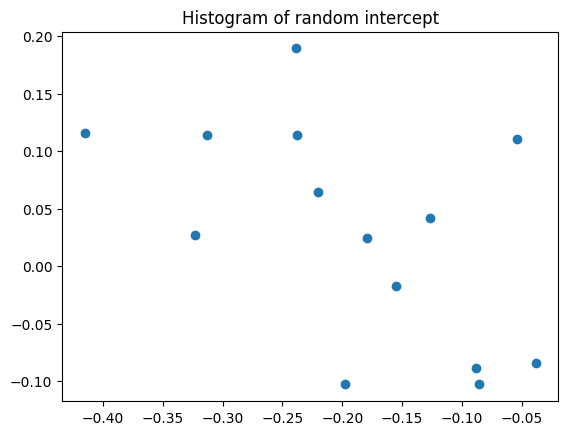

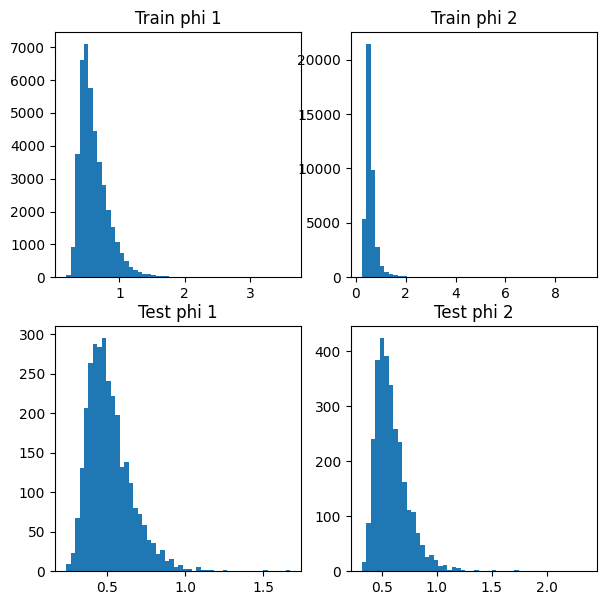

0-th epoch full h-lik loss (M-step) : 5.531794548034668
1-th epoch full h-lik loss (M-step) : 5.554497718811035
2-th epoch full h-lik loss (M-step) : 5.306612968444824
3-th epoch full h-lik loss (M-step) : 5.1643967628479
4-th epoch full h-lik loss (M-step) : 4.779065132141113
5-th epoch full h-lik loss (M-step) : 5.065464019775391
6-th epoch full h-lik loss (M-step) : 4.738405704498291
7-th epoch full h-lik loss (M-step) : 4.856888294219971
8-th epoch full h-lik loss (M-step) : 5.260584831237793
9-th epoch full h-lik loss (M-step) : 5.353196144104004
9-th V-step train loss : 5.234662055969238
19-th V-step train loss : 5.182584762573242
29-th V-step train loss : 5.147493362426758
39-th V-step train loss : 5.122387886047363
49-th V-step train loss : 5.103519439697266
59-th V-step train loss : 5.088138580322266
69-th V-step train loss : 5.075225830078125
79-th V-step train loss : 5.0639495849609375
89-th V-step train loss : 5.053831100463867
99-th V-step train loss : 5.044564723968506


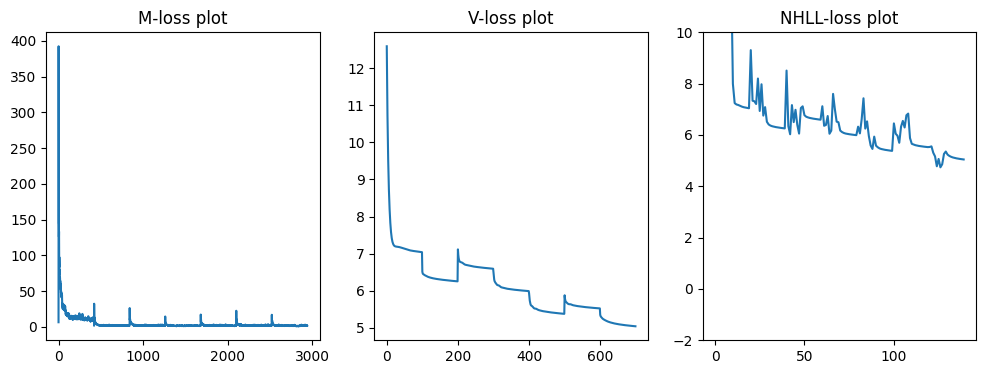

Train loss item : 5.044209957122803
6-th main train train MAE, MSE, NLL, NJLL, NHLL : 0.8204 deg, 0.4661, 3.3906, 4.0444,  5.0437
6-th main train test MAE, MSE, NLL : 5.1958 deg, 17.1015, 14.8954
6-th main train test MAE, MSE, NLL (adjusted y_hat) : 3.9681 deg, 11.0178, 15.5849


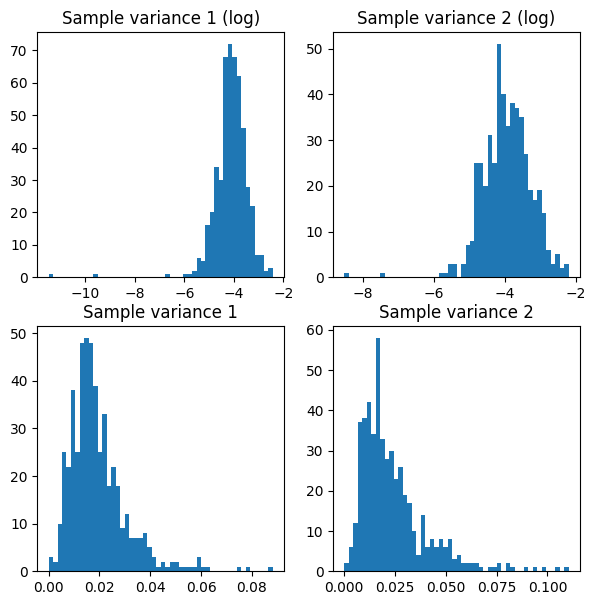

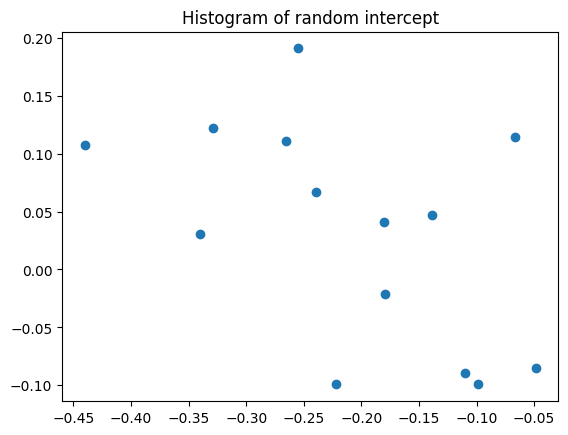

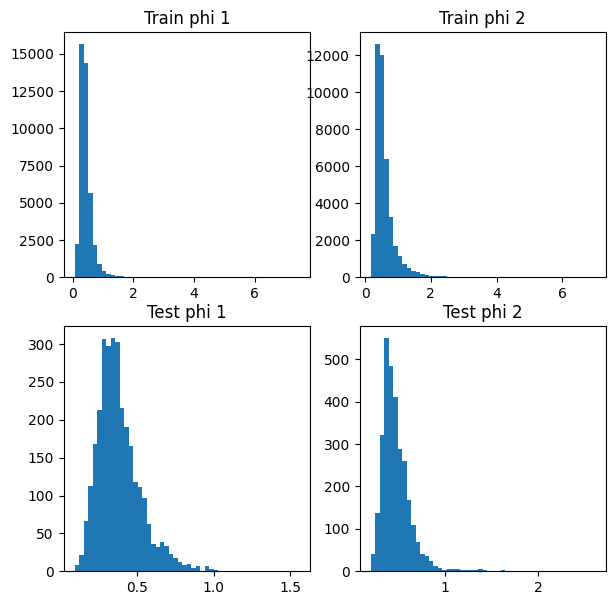

0-th epoch full h-lik loss (M-step) : 5.229371070861816
1-th epoch full h-lik loss (M-step) : 5.375690937042236
2-th epoch full h-lik loss (M-step) : 5.508761405944824
3-th epoch full h-lik loss (M-step) : 5.6653337478637695
4-th epoch full h-lik loss (M-step) : 5.147995948791504
5-th epoch full h-lik loss (M-step) : 4.467463493347168
6-th epoch full h-lik loss (M-step) : 5.821871280670166
7-th epoch full h-lik loss (M-step) : 5.010046005249023
8-th epoch full h-lik loss (M-step) : 6.603272914886475
9-th epoch full h-lik loss (M-step) : 5.668586730957031
9-th V-step train loss : 5.424142837524414
19-th V-step train loss : 5.363677024841309
29-th V-step train loss : 5.3209686279296875
39-th V-step train loss : 5.291693687438965
49-th V-step train loss : 5.271832466125488
59-th V-step train loss : 5.256845474243164
69-th V-step train loss : 5.244446277618408
79-th V-step train loss : 5.233467102050781
89-th V-step train loss : 5.223448753356934
99-th V-step train loss : 5.214213371276855

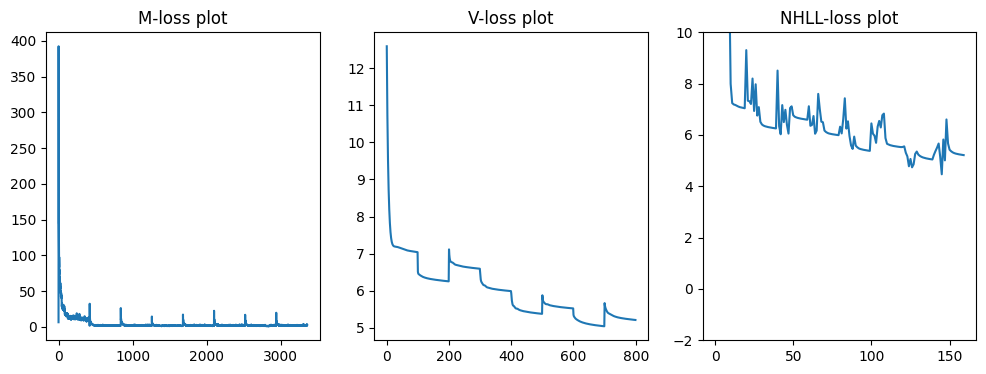

Train loss item : 5.2139129638671875
7-th main train train MAE, MSE, NLL, NJLL, NHLL : 0.9107 deg, 0.5466, 3.4283, 4.2121,  5.2133
7-th main train test MAE, MSE, NLL : 5.1214 deg, 16.5221, 14.1514
7-th main train test MAE, MSE, NLL (adjusted y_hat) : 3.7566 deg, 9.8750, 15.0085


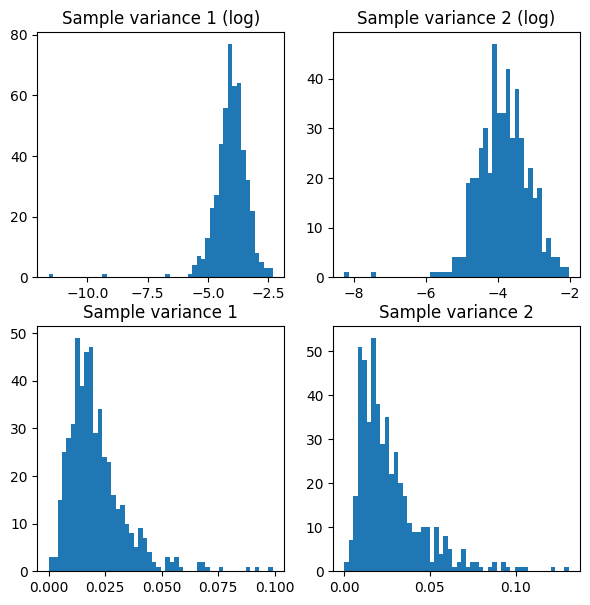

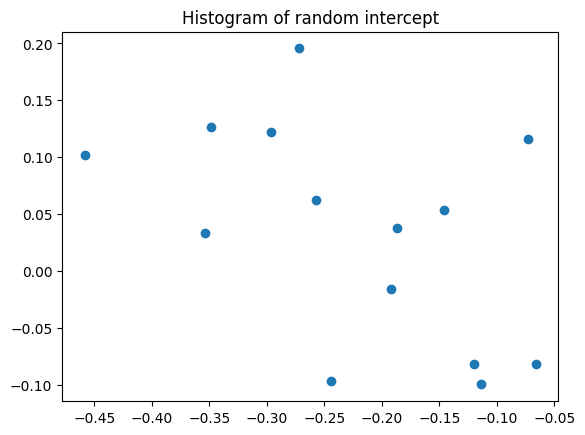

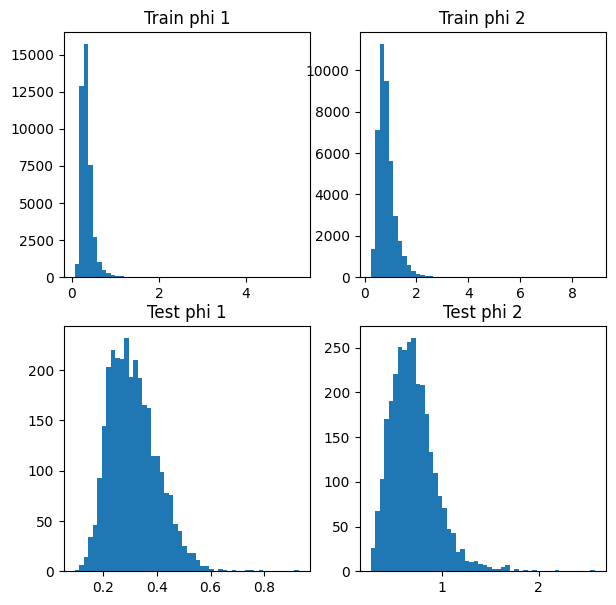

0-th epoch full h-lik loss (M-step) : 5.044507026672363
1-th epoch full h-lik loss (M-step) : 4.919862747192383
2-th epoch full h-lik loss (M-step) : 5.094452857971191
3-th epoch full h-lik loss (M-step) : 5.599936485290527
4-th epoch full h-lik loss (M-step) : 5.582283020019531
5-th epoch full h-lik loss (M-step) : 4.785224437713623
6-th epoch full h-lik loss (M-step) : 4.615034103393555
7-th epoch full h-lik loss (M-step) : 5.001720905303955
8-th epoch full h-lik loss (M-step) : 5.831233978271484
9-th epoch full h-lik loss (M-step) : 6.337620735168457
9-th V-step train loss : 5.752444744110107
19-th V-step train loss : 5.608674049377441
29-th V-step train loss : 5.5605854988098145
39-th V-step train loss : 5.519198417663574
49-th V-step train loss : 5.489012718200684
59-th V-step train loss : 5.46885871887207
69-th V-step train loss : 5.452223777770996
79-th V-step train loss : 5.438614845275879
89-th V-step train loss : 5.427176475524902
99-th V-step train loss : 5.4171061515808105


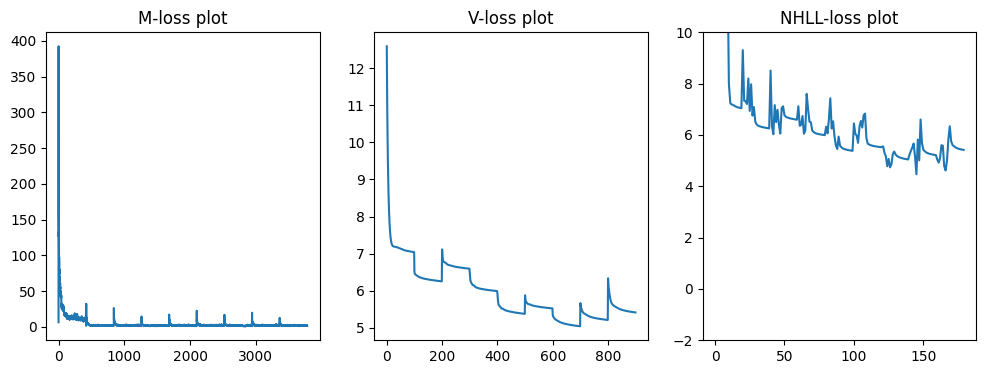

Train loss item : 5.41691780090332
8-th main train train MAE, MSE, NLL, NJLL, NHLL : 0.9784 deg, 0.6034, 3.5117, 4.4321,  5.4162
8-th main train test MAE, MSE, NLL : 4.9295 deg, 15.6706, 15.1175
8-th main train test MAE, MSE, NLL (adjusted y_hat) : 4.1609 deg, 11.5565, 16.0008


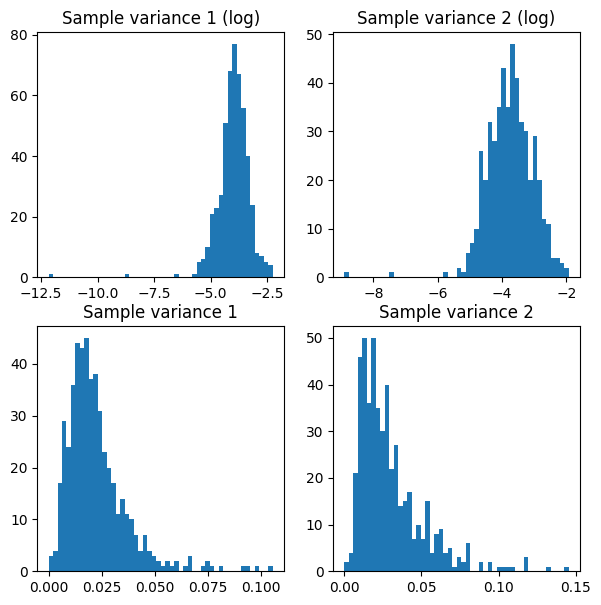

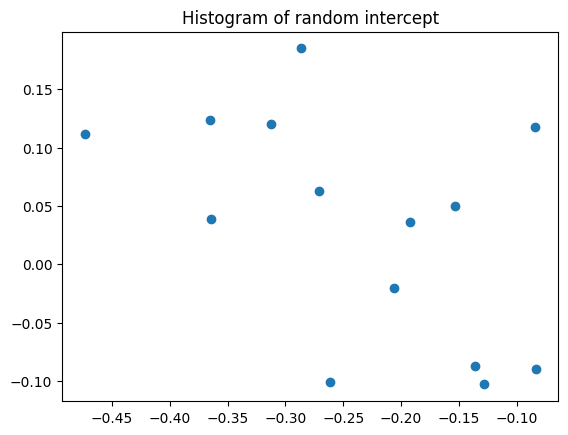

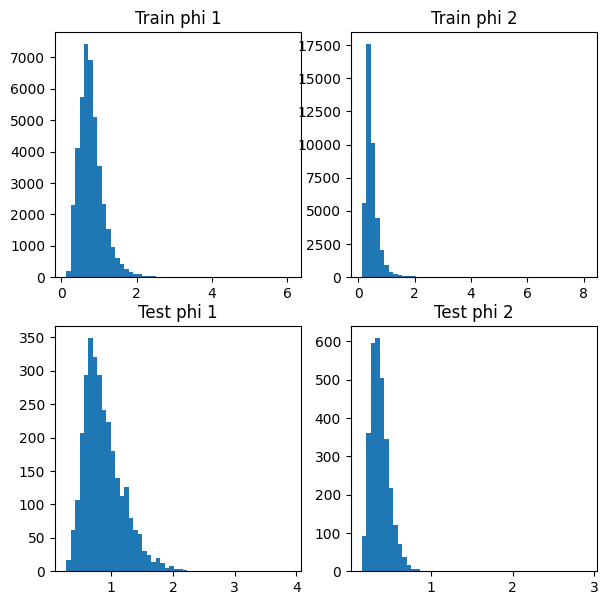

0-th epoch full h-lik loss (M-step) : 5.461652755737305
1-th epoch full h-lik loss (M-step) : 4.7374091148376465
2-th epoch full h-lik loss (M-step) : 4.6795806884765625
3-th epoch full h-lik loss (M-step) : 5.246472358703613
4-th epoch full h-lik loss (M-step) : 4.889646530151367
5-th epoch full h-lik loss (M-step) : 4.752249717712402
6-th epoch full h-lik loss (M-step) : 7.306323051452637
7-th epoch full h-lik loss (M-step) : 5.463996887207031
8-th epoch full h-lik loss (M-step) : 5.35919189453125
9-th epoch full h-lik loss (M-step) : 5.013987064361572
9-th V-step train loss : 4.771068572998047
19-th V-step train loss : 4.656510353088379
29-th V-step train loss : 4.611077308654785
39-th V-step train loss : 4.581964015960693
49-th V-step train loss : 4.563230037689209
59-th V-step train loss : 4.549456596374512
69-th V-step train loss : 4.538414001464844
79-th V-step train loss : 4.528996467590332
89-th V-step train loss : 4.520556449890137
99-th V-step train loss : 4.512813091278076


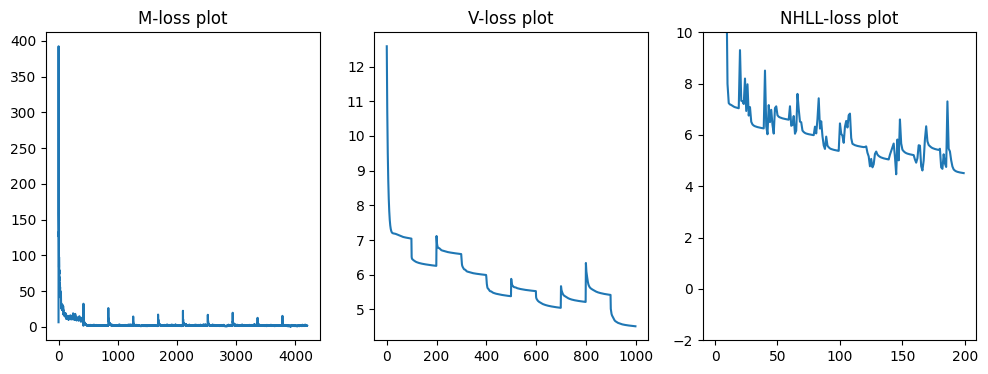

Train loss item : 4.512567043304443
9-th main train train MAE, MSE, NLL, NJLL, NHLL : 0.7327 deg, 0.3736, 2.9753, 3.4366,  4.5121
9-th main train test MAE, MSE, NLL : 5.1755 deg, 17.0852, 18.0982
9-th main train test MAE, MSE, NLL (adjusted y_hat) : 3.9677 deg, 10.9961, 19.2666


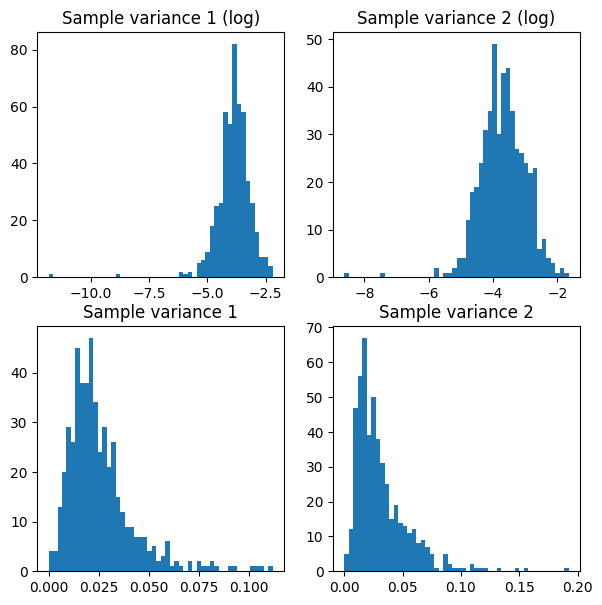

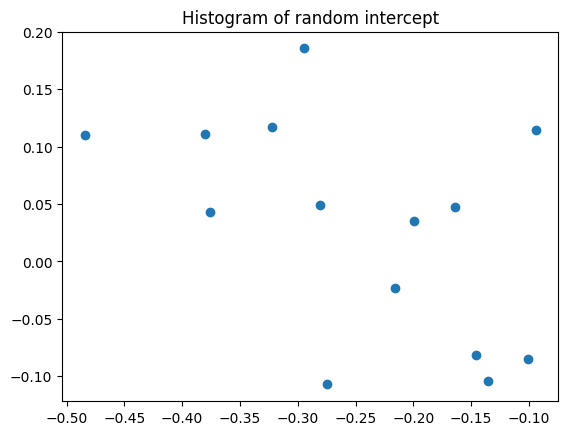

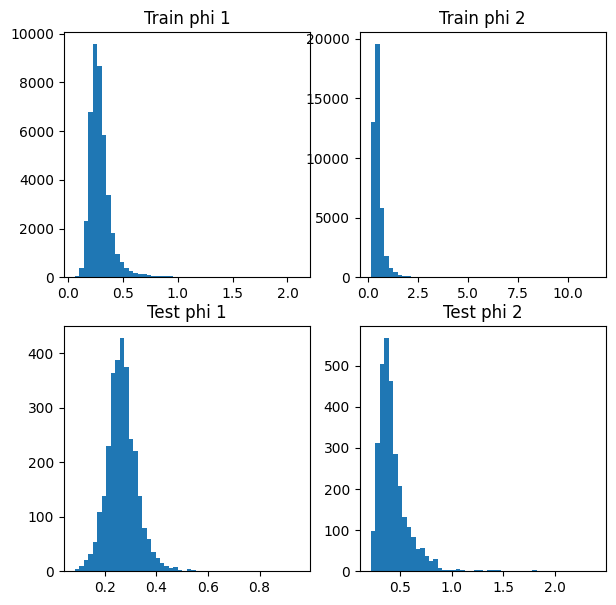

0-th epoch full h-lik loss (M-step) : 4.553645133972168
1-th epoch full h-lik loss (M-step) : 4.5083112716674805
2-th epoch full h-lik loss (M-step) : 3.8557894229888916
3-th epoch full h-lik loss (M-step) : 4.992961883544922
4-th epoch full h-lik loss (M-step) : 4.3150248527526855
5-th epoch full h-lik loss (M-step) : 4.786719799041748
6-th epoch full h-lik loss (M-step) : 4.389937400817871
7-th epoch full h-lik loss (M-step) : 4.664306640625
8-th epoch full h-lik loss (M-step) : 4.174997329711914
9-th epoch full h-lik loss (M-step) : 4.747885704040527
9-th V-step train loss : 4.678138732910156
19-th V-step train loss : 4.6447858810424805
29-th V-step train loss : 4.624175071716309
39-th V-step train loss : 4.609618663787842
49-th V-step train loss : 4.59763240814209
59-th V-step train loss : 4.58681583404541
69-th V-step train loss : 4.5769453048706055
79-th V-step train loss : 4.567863941192627
89-th V-step train loss : 4.559420585632324
99-th V-step train loss : 4.551515579223633


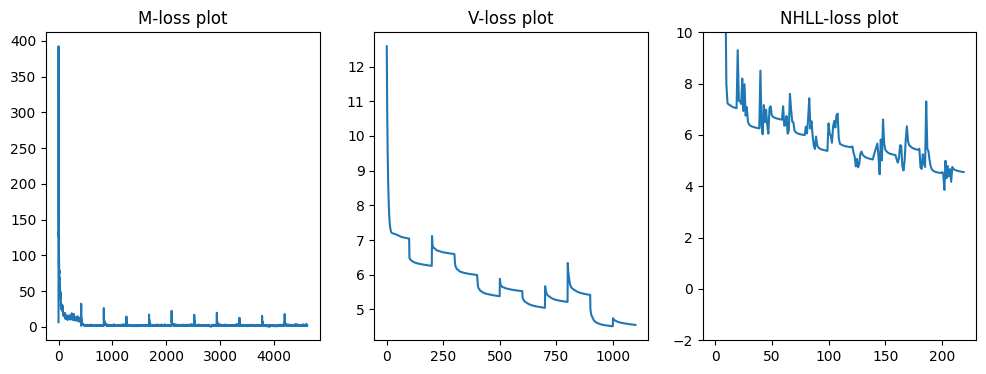

Train loss item : 4.551286220550537
10-th main train train MAE, MSE, NLL, NJLL, NHLL : 0.7688 deg, 0.3925, 2.8443, 3.4689,  4.5508
10-th main train test MAE, MSE, NLL : 5.1347 deg, 16.8444, 17.8160
10-th main train test MAE, MSE, NLL (adjusted y_hat) : 3.7193 deg, 9.4940, 18.8304


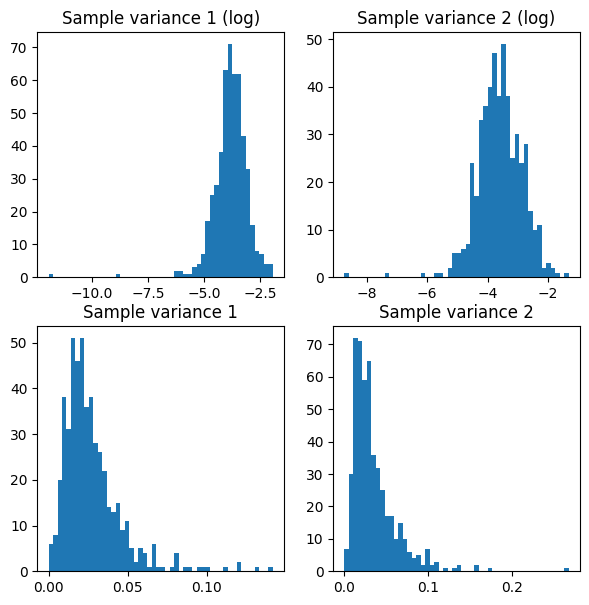

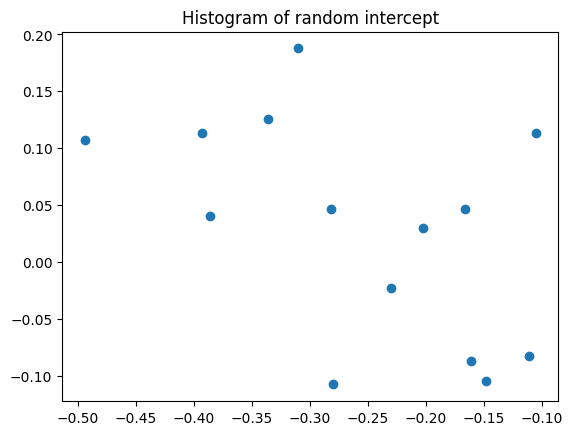

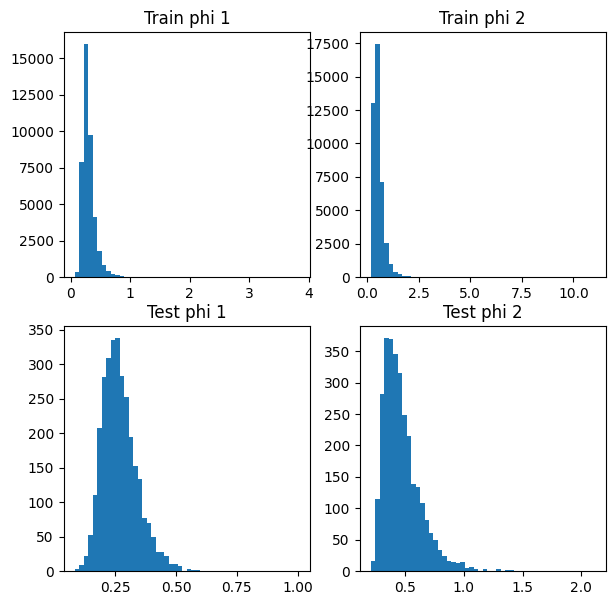

0-th epoch full h-lik loss (M-step) : 4.105993747711182
1-th epoch full h-lik loss (M-step) : 4.184741020202637
2-th epoch full h-lik loss (M-step) : 4.275093078613281
3-th epoch full h-lik loss (M-step) : 4.3572282791137695
4-th epoch full h-lik loss (M-step) : 6.265222549438477
5-th epoch full h-lik loss (M-step) : 4.667964935302734
6-th epoch full h-lik loss (M-step) : 4.824031829833984
7-th epoch full h-lik loss (M-step) : 4.389267921447754
8-th epoch full h-lik loss (M-step) : 4.468802452087402
9-th epoch full h-lik loss (M-step) : 5.034540176391602
9-th V-step train loss : 4.818800449371338
19-th V-step train loss : 4.74435567855835
29-th V-step train loss : 4.697551727294922
39-th V-step train loss : 4.671982288360596
49-th V-step train loss : 4.655256271362305
59-th V-step train loss : 4.642415523529053
69-th V-step train loss : 4.631693363189697
79-th V-step train loss : 4.622485160827637
89-th V-step train loss : 4.6143479347229
99-th V-step train loss : 4.607027053833008


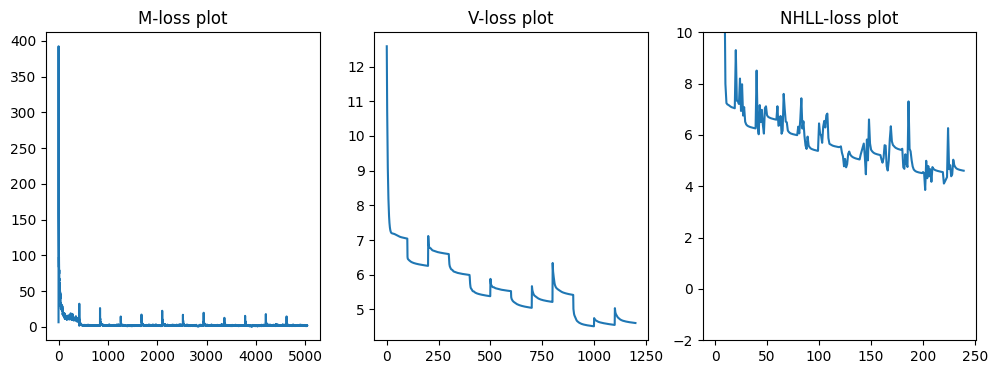

Train loss item : 4.606799602508545
11-th main train train MAE, MSE, NLL, NJLL, NHLL : 0.8297 deg, 0.4414, 2.7478, 3.5008,  4.6063
11-th main train test MAE, MSE, NLL : 5.0534 deg, 16.4181, 20.0121
11-th main train test MAE, MSE, NLL (adjusted y_hat) : 3.8403 deg, 10.1109, 21.2075


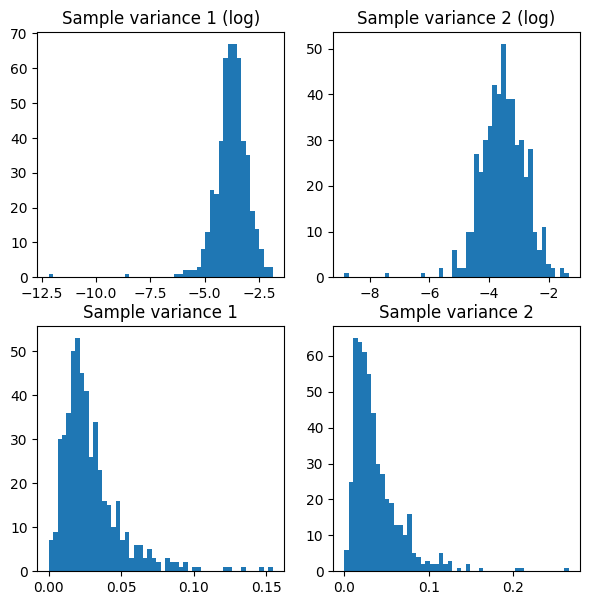

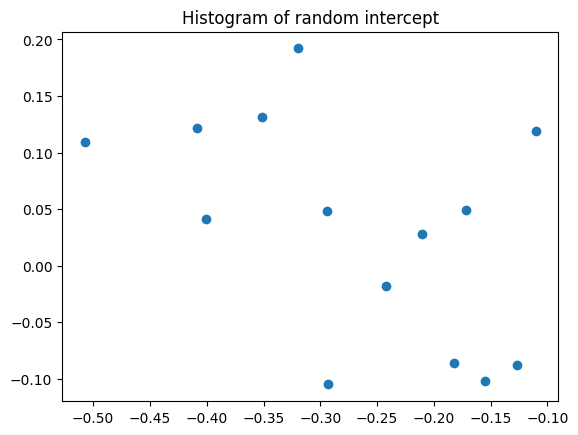

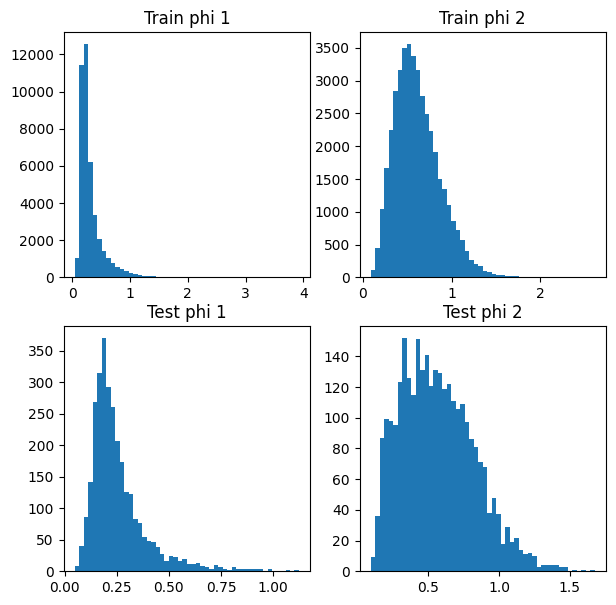

0-th epoch full h-lik loss (M-step) : 4.738489151000977
1-th epoch full h-lik loss (M-step) : 4.642473220825195
2-th epoch full h-lik loss (M-step) : 4.666962146759033
3-th epoch full h-lik loss (M-step) : 4.619399070739746
4-th epoch full h-lik loss (M-step) : 5.096959114074707
5-th epoch full h-lik loss (M-step) : 4.5007243156433105
6-th epoch full h-lik loss (M-step) : 4.692804336547852
7-th epoch full h-lik loss (M-step) : 5.002710342407227
8-th epoch full h-lik loss (M-step) : 4.9144368171691895
9-th epoch full h-lik loss (M-step) : 4.798810958862305
9-th V-step train loss : 4.534104347229004
19-th V-step train loss : 4.4663896560668945
29-th V-step train loss : 4.432765960693359
39-th V-step train loss : 4.407407760620117
49-th V-step train loss : 4.392338275909424
59-th V-step train loss : 4.380856990814209
69-th V-step train loss : 4.371646404266357
79-th V-step train loss : 4.363669395446777
89-th V-step train loss : 4.356555938720703
99-th V-step train loss : 4.35004949569702

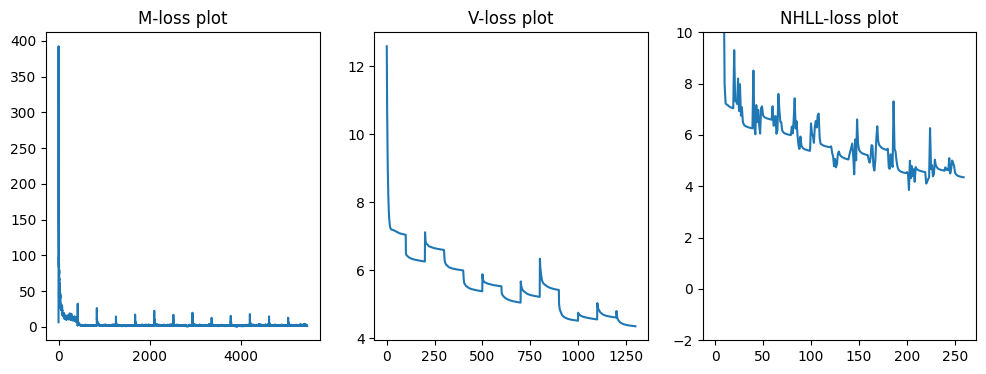

Train loss item : 4.349839210510254
12-th main train train MAE, MSE, NLL, NJLL, NHLL : 0.7621 deg, 0.4104, 2.6810, 3.2134,  4.3494
12-th main train test MAE, MSE, NLL : 5.3399 deg, 18.0779, 20.9313
12-th main train test MAE, MSE, NLL (adjusted y_hat) : 4.0224 deg, 11.5030, 22.4388


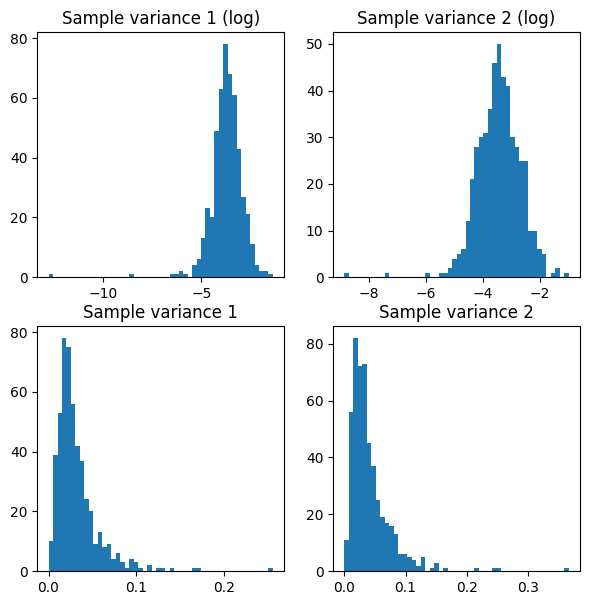

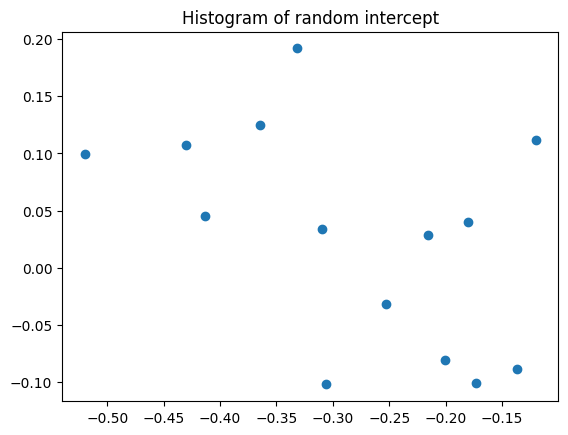

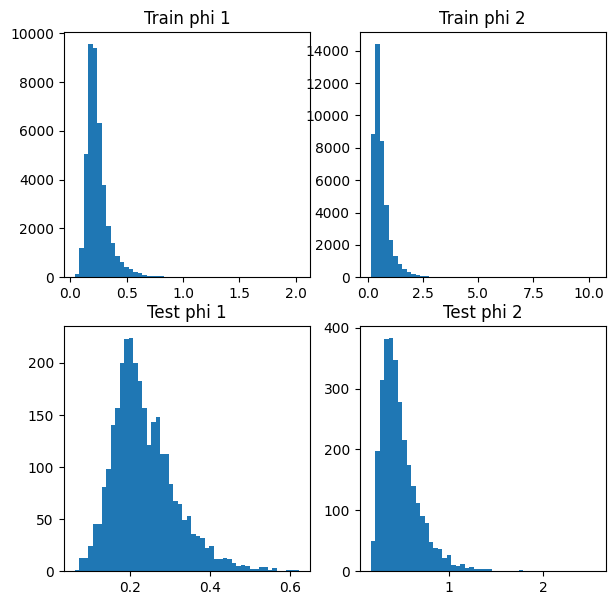

0-th epoch full h-lik loss (M-step) : 4.308376312255859
1-th epoch full h-lik loss (M-step) : 4.298778533935547
2-th epoch full h-lik loss (M-step) : 4.526028633117676
3-th epoch full h-lik loss (M-step) : 4.1234636306762695
4-th epoch full h-lik loss (M-step) : 4.826533794403076
5-th epoch full h-lik loss (M-step) : 4.098638534545898
6-th epoch full h-lik loss (M-step) : 3.80361270904541
7-th epoch full h-lik loss (M-step) : 5.078006267547607
8-th epoch full h-lik loss (M-step) : 4.278231620788574
9-th epoch full h-lik loss (M-step) : 4.558352470397949
9-th V-step train loss : 4.311981201171875
19-th V-step train loss : 4.246614456176758
29-th V-step train loss : 4.216777324676514
39-th V-step train loss : 4.192368984222412
49-th V-step train loss : 4.174890518188477
59-th V-step train loss : 4.160593032836914
69-th V-step train loss : 4.148873805999756
79-th V-step train loss : 4.138774871826172
89-th V-step train loss : 4.129915237426758
99-th V-step train loss : 4.121993541717529


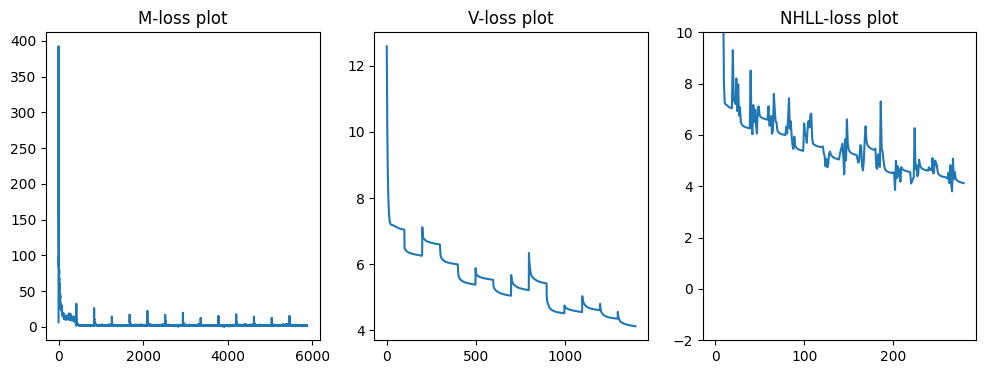

Train loss item : 4.121829986572266
13-th main train train MAE, MSE, NLL, NJLL, NHLL : 0.7024 deg, 0.3189, 2.3199, 2.9603,  4.1212
13-th main train test MAE, MSE, NLL : 5.1125 deg, 16.7255, 22.4241
13-th main train test MAE, MSE, NLL (adjusted y_hat) : 3.8838 deg, 10.4446, 24.0758


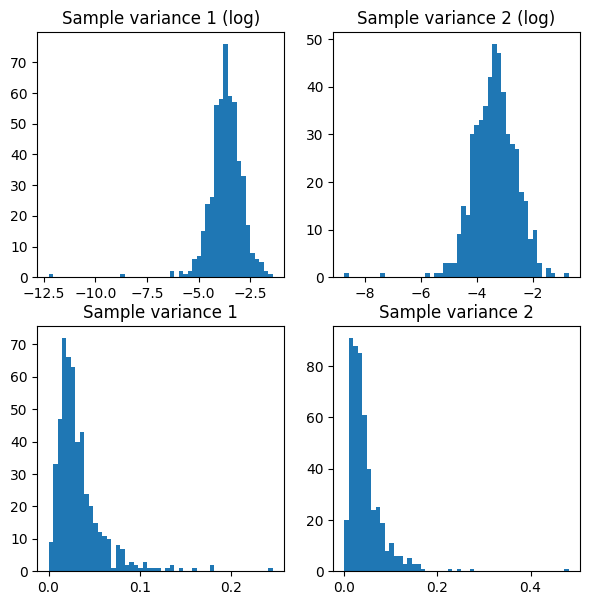

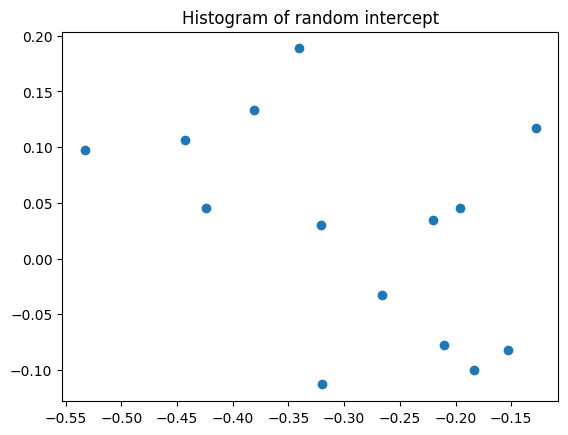

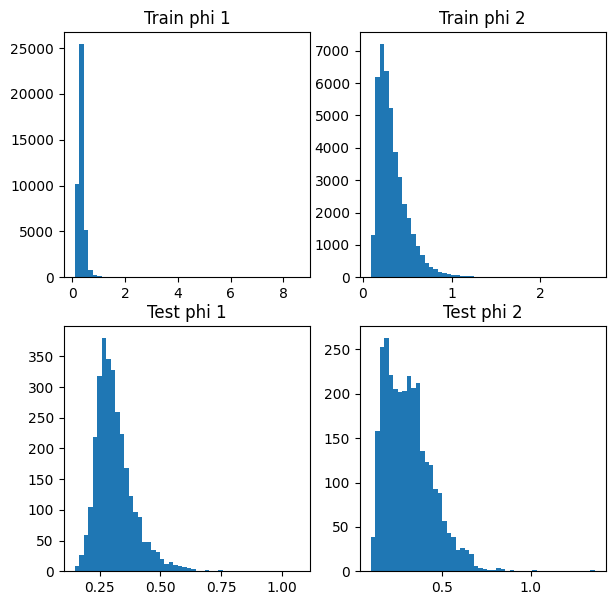

0-th epoch full h-lik loss (M-step) : 4.399934768676758
1-th epoch full h-lik loss (M-step) : 3.436967372894287
2-th epoch full h-lik loss (M-step) : 3.571558713912964
3-th epoch full h-lik loss (M-step) : 4.000072002410889
4-th epoch full h-lik loss (M-step) : 4.248863220214844
5-th epoch full h-lik loss (M-step) : 4.018243312835693
6-th epoch full h-lik loss (M-step) : 4.086251258850098
7-th epoch full h-lik loss (M-step) : 3.851912260055542
8-th epoch full h-lik loss (M-step) : 3.8061139583587646
9-th epoch full h-lik loss (M-step) : 4.789844036102295
9-th V-step train loss : 4.449697017669678
19-th V-step train loss : 4.394804000854492
29-th V-step train loss : 4.36775541305542
39-th V-step train loss : 4.345322608947754
49-th V-step train loss : 4.331369876861572
59-th V-step train loss : 4.321011543273926
69-th V-step train loss : 4.3121843338012695
79-th V-step train loss : 4.304547309875488
89-th V-step train loss : 4.297638893127441
99-th V-step train loss : 4.291265487670898


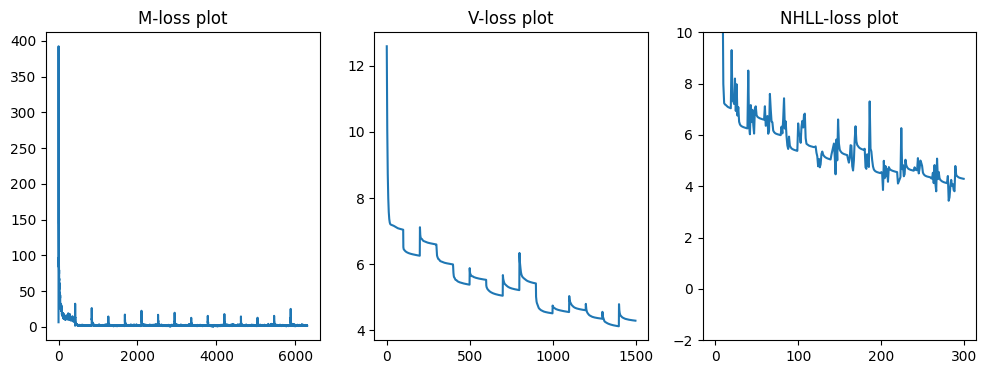

In [ ]:
#@title test


for looid in [0,1,2] :

    train_ids = np.concatenate(selected_ids[:looid] + selected_ids[(looid + 1):])
    train_images = torch.cat(selected_images[:looid] + selected_images[(looid + 1):]).float()
    train_hps = torch.cat(selected_head_poses[:looid] + selected_head_poses[(looid + 1):]).float()
    train_gazes = torch.cat(selected_gazes[:looid] + selected_gazes[(looid + 1):]).float()

    test_ids = selected_ids[looid]
    test_images = selected_images[looid].float()
    test_hps = selected_head_poses[looid].float()
    test_gazes = selected_gazes[looid].float()

    res_list.append(hetero_arbitrary_without_val(
        train_ids, train_images, train_hps, train_gazes,
        test_ids, test_images, test_hps, test_gazes,
        ResNet_batchnorm.ResNet_batchnorm, hidden_features=hidden_features, K=2,
        mean_lr=mean_lr, variance_lr=variance_lr, weight_decay=weight_decay, batch_size=batch_size,
        pretrain_iter=pretrain_iter, m_pretrain_epoch=m_pretrain_epoch, v_pretrain_epoch=v_pretrain_epoch, max_iter=max_iter, mean_epoch=mean_epoch, v_step_iter=v_step_iter, patience=patience,
        device=device, experiment_name=f'{experiment_name}_{looid}', SEED=seed + looid,
        normalize=True, deg=True, test_unseen=test_unseen, weighted=True, variance_check=True, verbose=False, bins=50, reset_opt=reset_opt))


